In [2]:
from functools import partial

import jax
import jax.numpy as np
import flax.linen as nn
import optax
import diffrax as dfx
import math

from sklearn import datasets, preprocessing

import matplotlib.pyplot as plt
from tqdm import trange

## The Dataset

(-2.0, 2.0)

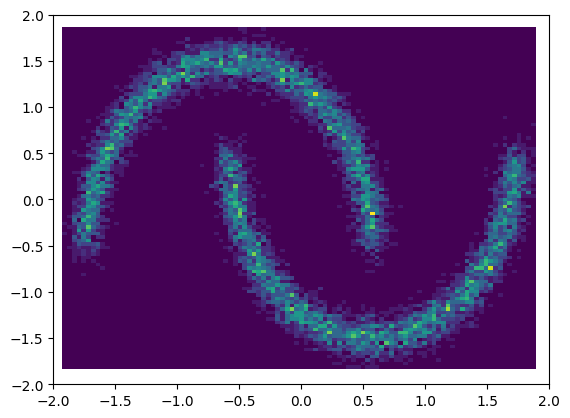

In [150]:
n_samples = 10_000

x, _ = datasets.make_moons(n_samples=n_samples, noise=.06)

scaler = preprocessing.StandardScaler()
x = scaler.fit_transform(x)

plt.hist2d(x[:, 0], x[:, 1], bins=100)
plt.xlim(-2 ,2)
plt.ylim(-2, 2)

## The Model

Based on https://docs.kidger.site/diffrax/examples/continuous_normalising_flow/.

In [151]:
class MLP(nn.Module):
    """ A simple MLP in Flax.
    """
    hidden_dim: int = 64
    out_dim: int = 2
    n_layers: int = 3

    @nn.compact
    def __call__(self, x):
        for _ in range(self.n_layers):
            x = nn.Dense(features=self.hidden_dim)(x)
            x = nn.gelu(x)
        x = nn.Dense(features=self.out_dim)(x)
        return x

In [152]:
key = jax.random.PRNGKey(0)
t = np.ones((x.shape[0], 1))

phi = MLP(hidden_dim=64, out_dim=2, n_layers=3)
params = phi.init(key, np.concatenate([x, t], axis=1))

In [153]:
def approx_logp_wrapper(t, y, args):
    """ Approx. log-likelihood using Hutchinson's trace estimator.
    """
    y, _ = y
    eps, func = args
    t = np.atleast_1d(t)
    fn = lambda y: func(np.concatenate([y, t]))
    f, vjp_fn = jax.vjp(fn, y)
    (eps_dfdy,) = vjp_fn(eps)
    logp = np.sum(eps_dfdy * eps)
    return f, logp

def exact_logp_wrapper(t, y, args):
    y, _ = y
    _, func = args
    t = np.atleast_1d(t)
    fn = lambda y: func(np.concatenate([y, t]))
    f, vjp_fn = jax.vjp(fn, y)
    (size,) = y.shape  # this implementation only works for 1D input
    eye = np.eye(size)
    (dfdy,) = jax.vmap(vjp_fn)(eye)
    logp = np.trace(dfdy)
    return f, logp

def normal_log_likelihood(y):
    return -0.5 * (y.size * math.log(2 * math.pi) + np.sum(y**2))

In [177]:
t0 = 0.0
t1 = 1
dt0 = 0.01


# Runs backward-in-time to train the CNF

@partial(jax.jit, static_argnums=(2,))
def loss_fn(params, y, phi):
    # term = dfx.ODETerm(approx_logp_wrapper)
    term = dfx.ODETerm(exact_logp_wrapper)
    solver = dfx.Heun()
    eps = jax.random.normal(key, y.shape)
    delta_log_likelihood = 0.0
    y = (y, delta_log_likelihood)
    func = lambda x: phi.apply(params, x)
    sol = dfx.diffeqsolve(
        term, solver, t1, t0, -dt0, y, (eps, func)
    )
    (y,), (delta_log_likelihood,) = sol.ys
    return delta_log_likelihood + normal_log_likelihood(y)

jax.vmap(loss_fn, in_axes=(None, 0, None))(params, x[:32], phi)

Array([-1.6846712 , -1.9114444 , -1.8168522 , -2.120591  , -1.2208896 ,
       -1.6959417 , -1.3939068 , -2.5613263 , -0.7033353 , -1.428375  ,
       -3.06819   , -1.7990499 , -0.85046446, -2.1790135 , -1.1367638 ,
       -2.8577878 , -1.2591357 , -1.2362309 , -1.8733677 , -1.3351643 ,
       -0.8699026 , -1.1454786 , -1.6781175 , -1.8426808 , -2.503341  ,
       -2.3927724 , -2.4980576 , -0.703164  , -2.0282063 , -1.4397151 ,
       -3.1072893 , -2.054167  ], dtype=float32)

In [178]:
opt = optax.adamw(learning_rate=1e-4, weight_decay=1e-4)
opt_state = opt.init(params)

def loss_fn_vmapped_summed(params, x_batch, phi):
    log_like = jax.vmap(loss_fn, in_axes=(None, 0, None))(params, x_batch, phi)
    return -log_like.mean()


In [179]:
n_steps = 1000
n_batch = 32

with trange(n_steps) as steps:
    for step in steps:

        # Draw a random batches from x
        key, subkey = jax.random.split(key)
        idx = jax.random.choice(key, x.shape[0], shape=(n_batch,))
        
        x_batch = x[idx]
        
        loss, grads = jax.value_and_grad(loss_fn_vmapped_summed)(params, x_batch, phi)
        updates, opt_state = opt.update(grads, opt_state, params)

        params = optax.apply_updates(params, updates)

        steps.set_postfix(val=loss)

100%|██████████| 1000/1000 [02:13<00:00,  7.47it/s, val=1.5971217]


In [180]:
def single_sample_fn(params, key, dim_data=2):
    y = jax.random.normal(key, (dim_data,))
    def func(t, x, args):
        t = np.atleast_1d(t)
        return phi.apply(params, np.concatenate([x, t]))
    term = dfx.ODETerm(func)
    solver = dfx.Heun()
    sol = dfx.diffeqsolve(term, solver, t0, t1, dt0, y)
    (y,) = sol.ys
    return y

single_sample_fn(params, key)

Array([-0.06627482, -0.45419675], dtype=float32, weak_type=True)

In [183]:
sample_fn = partial(single_sample_fn, params)

n_samples = 100
sample_key = jax.random.split(key, n_samples ** 2)
x_sample = jax.vmap(sample_fn)(sample_key)

(-2.0, 2.0)

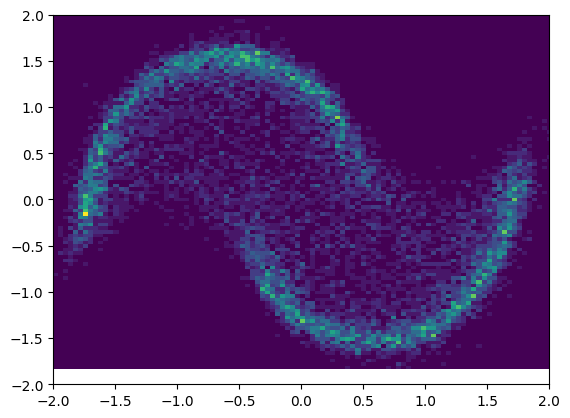

In [184]:

plt.hist2d(x_sample[:, 0], x_sample[:, 1], bins=100)
plt.xlim(-2 ,2)
plt.ylim(-2, 2)